In [1]:
!mkdir -p sentiment_classification/data

# 실습에 활용할 수 있도록 라이브러리 설치 및 다운그레이드를 수행합니다
!pip install gensim==4.3.2
!conda install scipy==1.12.0 numpy==1.26.3 -y

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 35.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-linux_x86_64.whl size=24072419 sha256=2ff8de505d9fbe500583257aaf49871f1906dc4ec2d7d4457627471f87f85c5f
  Stored in directory: /home/jovyan/.cache/pip/wheels/50/c0/ac/7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gensim]2m2/3 [gensim]pen]
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - numpy==1.26.3
    - scipy==1.12.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2025.7.14  |       hbd8a1cb_0       

In [2]:
"""
2. 텍스트 감정분석의 유용성
오늘 우리는 딥러닝을 통해 텍스트에 담긴 감성을 분석(Sentimental Analysis)하는 방법을 
배워 볼 것입니다. 구체적으로는 IMDB나 네이버 영화 리뷰 텍스트에 담긴 이용자의 감성이 
긍정적인지 혹은 부정적인지를 분류(Classification) 할 수 있는 딥러닝 모델을 만들어 볼 
것입니다.
그런데 딥러닝을 이용한 텍스트 감성분석은 어떤 점에서 유용할까요? 
이 막연한 질문을 좀 더 세부적인 질문으로 잘게 쪼개면 다음과 같은 질문들로 나눠볼 수
있을 것입니다.

텍스트 데이터만이 가지고 있는 정보적 특성과 가치는 어떤 것일까요?
감성분석 등 텍스트 분류 모델이 다른 데이터 분석 업무에 어떤 점에서 도움을 주나요?
텍스트 데이터 분석의 기술적 어려움은 무엇인가요?
텍스트 분류 작업을 하는데 딥러닝이 적용되면 어떤 점에서 유리해질까요?

이 질문들에 답을 제공하는 유용한 아티클 하나를 소개하겠습니다. 
이 아티클을 정독하시면서 위 질문들에 대한 답을 찾아서 스스로 정리해 보시기 바랍니다. 
하지만 정답이 있는 것은 아닙니다.
이 아티클을 통해 산업 현장에서 텍스트 분류가 실제로 활용되는 구체적인 사례도 확인할 수 있습니다.

동아비즈니스리뷰 감성분석 활용 사례 기고
https://dbr.donga.com/article/view/1202/article_no/8891/ac/magazine

3. 텍스트 데이터의 특징
인공지능 모델을 입력과 출력이 정해진 함수라고 생각해 봅시다. 예를 들어 MNIST 숫자 분류기 모델이라면 이미지 파일을 읽어 들인 매트릭스가 입력이 되고, 이미지 파일에 쓰여 있는 실제 숫자 값이 출력이 되는 함수가 될 것입니다.
이제 텍스트 문장을 입력으로 받아서 그 의미가 긍정이면 1, 부정이면 0을 출력하는 인공지능 모델을 만든다고 생각해 봅시다. 이 모델을 만들기 위해서는 숫자 분류기를 만들 때는 생각할 필요가 없었던 2가지 문제가 생깁니다.

텍스트를 어떻게 숫자 행렬로 표현할 수 있나요?
텍스트에는 순서가 중요합니다. 입력 데이터의 순서를 인공지능 모델에 어떻게 반영해야 하나요?
위 두 문제를 해결하기 위해, 일반적으로 Encoding 과 Embedding이라는 두 가지 기법을 사용합니다.
각각의 방식을 어떻게 수행하며, 어떤 차이를 가지는지 살펴보겠습니다.

(1) 텍스트를 숫자로 표현하는 방법
인공지능 모델의 입력이 될 수 있는 것은 0과 1의 비트로 표현 가능한 숫자만으로 이루어진 매트릭스일 뿐입니다.
아주 단순히, A=0, B=1, ..., Z=25 라고 숫자를 임의로 부여한다고 해봅시다.
그러면 의미적으로 A와 B는 1만큼 멀고, A와 Z는 25만큼 멀까요? 그렇지 않습니다. 텍스트의 중요한 특징은 그 자체로는 기호일 뿐이며, 텍스트가 내포하는 의미를 기호가 직접 내포하지 않는다는 점입니다.

하지만 우리는 우선 단어 사전을 만들어 볼 수는 있습니다. 우리가 사용하는 국어, 영어 사전에는 단어와 그 의미 설명이 짝지어져 있습니다.
우리가 하려는 것은 단어와 그 단어의 의미를 나타내는 벡터를 짝지어 보려고 하는 것입니다. 그런데 그 벡터는 어디서 가져올까요? 그렇습니다. 우리는 딥러닝을 통해 그 벡터를 만들어 낼 수 있습니다.

아래와 같이 단 3개의 짧은 문장으로 이루어진 텍스트 데이터를 처리하는 간단한 예제를 생각해 보겠습니다.

"""

'\n2. 텍스트 감정분석의 유용성\n오늘 우리는 딥러닝을 통해 텍스트에 담긴 감성을 분석(Sentimental Analysis)하는 방법을 \n배워 볼 것입니다. 구체적으로는 IMDB나 네이버 영화 리뷰 텍스트에 담긴 이용자의 감성이 \n긍정적인지 혹은 부정적인지를 분류(Classification) 할 수 있는 딥러닝 모델을 만들어 볼 \n것입니다.\n그런데 딥러닝을 이용한 텍스트 감성분석은 어떤 점에서 유용할까요? \n이 막연한 질문을 좀 더 세부적인 질문으로 잘게 쪼개면 다음과 같은 질문들로 나눠볼 수\n있을 것입니다.\n\n텍스트 데이터만이 가지고 있는 정보적 특성과 가치는 어떤 것일까요?\n감성분석 등 텍스트 분류 모델이 다른 데이터 분석 업무에 어떤 점에서 도움을 주나요?\n텍스트 데이터 분석의 기술적 어려움은 무엇인가요?\n텍스트 분류 작업을 하는데 딥러닝이 적용되면 어떤 점에서 유리해질까요?\n\n이 질문들에 답을 제공하는 유용한 아티클 하나를 소개하겠습니다. \n이 아티클을 정독하시면서 위 질문들에 대한 답을 찾아서 스스로 정리해 보시기 바랍니다. \n하지만 정답이 있는 것은 아닙니다.\n이 아티클을 통해 산업 현장에서 텍스트 분류가 실제로 활용되는 구체적인 사례도 확인할 수 있습니다.\n\n동아비즈니스리뷰 감성분석 활용 사례 기고\nhttps://dbr.donga.com/article/view/1202/article_no/8891/ac/magazine\n'

In [3]:
# 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.
sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [4]:
index_to_word={}  # 빈 딕셔너리를 만들어서

# 단어들을 하나씩 채워 봅니다. 채우는 순서는 일단 임의로 하였습니다. 그러나 사실 순서는 중요하지 않습니다.
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다.
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [5]:
# 단어 10개짜리 작은 딕셔너리가 만들어졌습니다. 하지만 우리가 가진 텍스트 데이터를 
# 숫자로 바꿔 보려고 하는데, 텍스트를 숫자로 바꾸려면 위의 딕셔너리가 
# {텍스트:인덱스} 구조여야 합니다.

word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [6]:
# 이 딕셔너리는 단어를 주면 그 단어의 인덱스를 반환하는 방식으로 사용할 수 있습니다.
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


In [7]:
# 이제 우리가 가진 텍스트 데이터를 숫자로 바꿔 표현해 봅시다.
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index))

[1, 3, 6, 7]


In [8]:
"""
get_encoded_sentence 함수를 통해 아래와 같이 매핑된 것이 확인되시나요?

<BOS> -> 1
i -> 3
eat -> 6
lunch -> 7
이렇게 텍스트 혹은 범주형 데이터를 정수에 대응하는 방법을 ‘정수 인코딩’ 이라고 합니다. 
인코딩은 이 외에도 원-핫 인코딩, 멀티-핫 인코딩 등이 있습니다.
"""

'\nget_encoded_sentence 함수를 통해 아래와 같이 매핑된 것이 확인되시나요?\n\n<BOS> -> 1\ni -> 3\neat -> 6\nlunch -> 7\n이렇게 텍스트 혹은 범주형 데이터를 정수에 대응하는 방법을 ‘정수 인코딩’ 이라고 합니다. 인코딩은 이 외에도 원-핫 인코딩, 멀티-핫 인코딩 등이 있습니다.\n'

In [9]:
# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# sentences=['i feel hungry', 'i eat lunch', 'now i feel happy'] 가 아래와 같이 변환됩니다.
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [10]:
# 반대로, encode된 벡터를 decode하여 다시 원래 텍스트 데이터로 복구할 수도 있습니다.
# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [ ]:
"""
여기서 정의된 함수들은 이후 스텝들에서 반복해서 활용됩니다.

(2) Embedding 레이어의 등장
텍스트가 숫자로 변환되어 인공지능 모델의 입력으로 사용될 수 있게 되었지만, 
이것으로 충분하지는 않습니다. 'i feel hungry'가 1, 3, 4, 5 로 변환되었지만 
이 벡터는 텍스트에 담긴 언어의 의미와 대응되는 벡터가 아니라 임의로 부여된 
단어의 순서에 불과합니다. 우리가 하려는 것은 단어와 그 단어의 의미를 나타내는 
벡터를 짝짓는 것이었습니다. 그래서 단어의 의미를 나타내는 벡터를 훈련 가능한 
파라미터로 놓고 이를 딥러닝을 통해 학습해서 최적화하게 됩니다. 
Tensorflow, Pytorch 등의 딥러닝 프레임워크들은 이러한 의미 벡터 파라미터를 
구현한 Embedding 레이어를 제공합니다.
"""
"""
임베딩(Embedding)이란?
자연어 처리(Natural Language Processing)분야에서 임베딩(Embedding)은 사람이 쓰는 
자연어를 기계가 이해할 수 있는 숫자형태인 vector로 바꾼 결과 혹은 그 일련의 과정 
전체를 의미한다. 가장 간단한 형태의 임베딩은 단어의 빈도를 그대로 벡터로 사용하는 것이다.
임베딩을 통해 할수있는 것은 단어나 문장 사이의 코사인 유사도가 가장 높은 단어를 
구하는 등의 계산, 단어들 사이의 의미/문법적 정보 도출 벡터 간 연산으로 단어 사이 
문법적 관계 도출, 전이 학습(transfer learning)
임베딩은 다른 딥러닝 모델의 입력값으로 자주 쓰이고, 품질 좋은 임베딩을 쓸수록 모델의 성능이
좋아집니다.
"""

In [11]:
# 아래 코드는 그대로 실행하시면 에러가 발생할 것입니다.

import torch
import torch.nn as nn
import numpy as np
import os

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=word_vector_dim, padding_idx=0)

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다.
raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index), dtype='object')
raw_inputs_tensor = torch.tensor(raw_inputs, dtype=torch.long)
output = embedding(raw_inputs_tensor)
print(output)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
"""
실행해 보니 에러가 발생합니다. 왜 그럴까요?

주의해야 할 점이 있습니다. Embedding 레이어의 인풋이 되는 문장 벡터는 그 길이가 일정해야 합니다. raw_inputs의 3개 벡터의 길이는 각각 4, 4, 5입니다.
Pytorch에서는 torch.nn.utils.rnn.pad_sequence라는 편리한 함수를 통해 문장 벡터 뒤에 패딩(<PAD>)을 추가하여 길이를 일정하게 맞춰주는 기능을 제공합니다.
"""

In [12]:
import torch.nn.functional as F

raw_inputs = [torch.tensor(sentence, dtype=torch.long) for sentence in raw_inputs]
raw_inputs = torch.nn.utils.rnn.pad_sequence(raw_inputs, batch_first=True, padding_value=word_to_index['<PAD>'])
print(raw_inputs)

tensor([[1, 3, 4, 5, 0],
        [1, 3, 6, 7, 0],
        [1, 8, 3, 4, 9]])


In [ ]:
"""
짧은 문장 뒤쪽이 0으로 채워지는 것을 확인할 수 있습니다. <PAD> 가 0에 매핑되어 있다는 걸 기억하세요.

그러면 위에 시도했던 output = embedding(raw_inputs)을 다시 시도해 봅시다.
"""

In [13]:
vocab_size = len(word_to_index)   # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4   # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = nn.Embedding(vocab_size, word_vector_dim, padding_idx=word_to_index['<PAD>'])

# nn.Embedding를 통해 word vector를 모두 일정 길이로 맞춰주어야
# embedding 레이어의 input이 될 수 있음에 주의해 주세요.
encoded_sentences = get_encoded_sentences(sentences, word_to_index)
maxlen = 5
padded_sentences = [sentence + [word_to_index['<PAD>']] * (maxlen - len(sentence)) if len(sentence) < maxlen else sentence[:maxlen] for sentence in encoded_sentences]

raw_inputs = torch.tensor(padded_sentences, dtype=torch.long)
output = embedding(raw_inputs)
print(output)

tensor([[[ 0.9413, -0.4875, -0.0331,  0.2379],
         [ 1.4724, -0.2652,  0.2035, -0.0043],
         [ 1.9105,  0.4566, -1.1188,  0.6647],
         [ 2.8405, -1.3145, -0.9470, -0.3501],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.9413, -0.4875, -0.0331,  0.2379],
         [ 1.4724, -0.2652,  0.2035, -0.0043],
         [ 0.5827,  0.4917,  0.0386, -0.1711],
         [ 1.2814, -1.2754,  1.0766, -0.1017],
         [ 0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 0.9413, -0.4875, -0.0331,  0.2379],
         [ 2.2748, -0.1622, -1.2790, -0.7899],
         [ 1.4724, -0.2652,  0.2035, -0.0043],
         [ 1.9105,  0.4566, -1.1188,  0.6647],
         [-2.4637,  1.2624, -0.0161,  0.0233]]], grad_fn=<EmbeddingBackward0>)


In [ ]:
"""
4. 시퀀스 데이터를 다루는 RNN
텍스트 데이터를 다루는 데 주로 사용되는 딥러닝 모델은 바로 Recurrent Neural Network(RNN)입니다. RNN은 시퀀스(Sequence) 형태의 데이터를 처리하기에 최적인 모델로 알려져 있습니다.

텍스트 데이터도 시퀀스 데이터라는 관점으로 해석할 수 있습니다만, 시퀀스 데이터의 정의에 
가장 잘 어울리는 것은 음성 데이터가 아닐까 합니다. 시퀀스 데이터란 바로 입력이 시간 축을 
따라 발생하는 데이터입니다. 예를 들어 이전 스텝의 'i feel hungry'라는 문장을 누군가가 
초당 한 단어씩, 3초에 걸쳐 이 문장을 발음했다고 합시다.

at time=0s : 듣는이의 귀에 들어온 input='i'
at time=1s : 듣는이의 귀에 들어온 input='feel'
at time=2s : 듣는이의 귀에 들어온 input='hungry'
time=1s인 시점에서 입력으로 받은 문장은 'i feel' 까지입니다. 그다음에 'hungry'가 올지, 
'happy'가 올지 알 수 없는 상황입니다. RNN은 그런 상황을 묘사하기에 가장 적당한 모델 구조를
가지고 있습니다. 왜냐하면 RNN은 시간의 흐름에 따라 새롭게 들어오는 입력에 따라 변하는 
현재 상태를 묘사하는 state machine으로 설계되었기 때문입니다.

State가 무엇인지 이해를 돕기 위해 다음 그림을 보면서 질문에 대답해 봅시다.

https://www.slideshare.net/xguru/ss-16106464

[State가 유지된다는 것의 의미]

다음 동영상을 통해 RNN의 기본 개념과 설계 구조를 좀 더 구체적으로 확인해 본 후 다음 
질문에 대답해 봅시다.

김성훈 교수의 모두의 딥러닝 강좌 12강.RNN
https://www.youtube.com/watch?v=-SHPG_KMUkQ

"""

In [14]:
# 그러면 RNN 모델을 사용하여 이전 스텝의 텍스트 데이터를 처리하는 예제 코드를 구현해 보겠습니다.
class Model_1(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        self.fc1 = nn.Linear(8, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n[-1]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10   # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다.
model = Model_1(vocab_size, word_vector_dim)

print(model)

Model_1(
  (embedding): Embedding(10, 4)
  (lstm): LSTM(4, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
# 시퀀스 자료형과 RNN에 대해 조금더 쉽게 이해하고 싶다면 아래 링크(24분~55분)를 참고해주세요! 
# 시퀀스 자료형과 RNN   https://www.youtube.com/watch?v=mG6N0ut9dog&t=1447s

In [ ]:
"""
5. 꼭 RNN이어야 할까?
텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Neural Network(1-D CNN)를 사용할 
수도 있습니다.
우리는 이미지 분류기를 구현하면서 2-D CNN을 이미 사용해 본 바 있습니다. 이미지는 시퀀스
데이터가 아닙니다. 
이미지 분류기 모델에는 이미지 전체가 한꺼번에 입력으로 사용됩니다.
그러므로 1-D CNN은 문장 전체를 한꺼번에 한 방향으로 길이 7짜리 필터로 스캐닝 하면서 
7단어 이내에서 발견되는 특징을 추출하여 그것으로 문장을 분류하는 방식으로 사용됩니다.
이 방식도 텍스트를 처리하는 데 RNN 못지않은 효율을 보여줍니다.
그리고 CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 
진행된다는 장점이 있습니다.

"""

In [15]:
class Model_2(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_2, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.conv1 = nn.Conv1d(word_vector_dim, 16, kernel_size=7)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10    # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
model = Model_2(vocab_size, word_vector_dim)

print(model)

Model_2(
  (embedding): Embedding(10, 4)
  (conv1): Conv1d(4, 16, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
"""
아주 간단히는 GlobalMaxPooling1D() 레이어 하나만 사용하는 방법도 생각해 볼 수 있습니다. 
이 방식은 전체 문장 중에서 단 하나의 가장 중요한 단어만 피처로 추출하여 그것으로 문장의 
긍정/부정을 평가하는 방식이라고 생각할 수 있는데, 의외로 성능이 잘 나올 수도 있습니다.
"""

In [16]:
class Model_3(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_3, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(word_vector_dim, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

vocab_size = 10   # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다.
model = Model_3(vocab_size, word_vector_dim)

print(model)

Model_3(
  (embedding): Embedding(10, 4)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
"""
이 외에도 1-D CNN과 RNN 레이어를 섞어 쓴다거나, FFN(FeedForward Network) 레이어만으로 
구성하거나, 혹은 최근 각광받고 있는 Transformer 레이어를 쓰는 등 매우 다양한 시도를 
해볼 수 있습니다. 조금더 깊게 알고 싶다면 여기를 참고 하세요
https://wikidocs.net/80437
"""

In [ ]:
"""
6. IMDB 영화리뷰 감성분석
(1) IMDB 데이터셋 분석
이제 본격적으로 IMDb 영화리뷰 감성분석 태스크에 도전해 보겠습니다. 
IMDb Large Movie Dataset은 50000개의 영어로 작성된 영화 리뷰 텍스트로 구성되어 있으며, 
긍정은 1, 부정은 0의 라벨이 달려 있습니다. 2011년 Learning Word Vectors for Sentiment A
nalysis 논문에서 이 데이터셋을 소개하였습니다.

50000개의 리뷰 중 절반인 25000개가 훈련용 데이터, 나머지 25000개를 테스트용 데이터로 
사용하도록 지정되어 있습니다. 이 데이터셋은 tensorflow Keras 데이터셋 안에 포함되어 
있어서 손쉽게 다운로드하여 사용할 수 있습니다.
이후 스텝의 IMDb 데이터셋 처리 코드 중 일부는 Tensorflow 튜토리얼에 언급된 데이터 전처리 
로직을 참고하였음을 밝힙니다.
"""

In [27]:
!ln -s /home/jovyan/data /home/jovyan/work/sentiment_classification/

ln: failed to create symbolic link '/home/jovyan/work/sentiment_classification/data': File exists


In [28]:
# 원본 IMDb 데이터셋 다운로드
# import tensorflow as tf
# imdb = tf.keras.datasets.imdb

# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

# 이번 실습에서는 미리 다운로드된 데이터셋을 불러와 활용하겠습니다
data_dir = os.path.join(os.getenv('HOME') + '/work/sentiment_classification/data/')

x_train = np.load(data_dir + 'imdb_x_train.npy', allow_pickle=True)
y_train = np.load(data_dir + 'imdb_y_train.npy', allow_pickle=True)
x_test = np.load(data_dir + 'imdb_x_test.npy', allow_pickle=True)
y_test = np.load(data_dir + 'imdb_y_test.npy', allow_pickle=True)
print(f"훈련 샘플 개수: {len(x_train)}, 테스트 개수: {len(x_test)}")

훈련 샘플 개수: 25000, 테스트 개수: 25000


In [ ]:
"""
imdb.load_data() 호출 시 단어사전에 등재할 단어의 개수(num_words)를 10000으로 지정하면,
그 개수만큼의 word_to_index 딕셔너리까지 생성된 형태로 데이터셋이 생성됩니다.

다운로드한 데이터 실제 예시를 확인해 보겠습니다.
"""

In [29]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [ ]:
"""
텍스트 데이터가 아니라 이미 숫자로 encode된 텍스트 데이터를 다운로드했음을 확인할 
수 있습니다.
이미 텍스트가 encode되었으므로 IMDb 데이터셋에는 encode에 사용한 딕셔너리까지
함께 제공합니다.
"""

In [30]:
# word_to_index = imdb.get_word_index()
word_to_index = np.load(data_dir + 'imdb_word_to_index.pickle', allow_pickle=True)
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다.
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [ ]:
"""
여기서 주의할 점이 있습니다. IMDb 데이터셋의 텍스트 인코딩을 위한 word_to_index, 
index_to_word는 보정이 필요한데요.

예를 들어 다음 코드를 실행시켜보면 보정이 되지 않은 상태라 문장이 이상함을 확인하실 
겁니다. (뒤에 보정 후 다시 확인해볼 예정이에요.😊)
"""

In [31]:
# 보정 전 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room and it so heart shows to years of every never going and help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but and to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other and in of seen over landed for anyone of and br show's to whether from than out themselves history he name half some br of and odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but when from one bit then have two of

In [ ]:
"""
그럼 매핑 보정 작업을 해보겠습니다. 아래 내용은 Tensorflow 튜토리얼의 가이드를 
반영하여 작성하였습니다.
word_to_index는 IMDb 텍스트 데이터셋의 단어 출현 빈도 기준으로 내림차수 
정렬되어 있습니다.
"""

In [32]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다.
print(word_to_index['the'])  # 4 이 출력됩니다.
print(index_to_word[4])     # 'the' 가 출력됩니다.

# 보정 후 x_train[0] 데이터
print(get_decoded_sentence(x_train[0], index_to_word))

<BOS>
4
the
this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for

In [ ]:
"""
다운로드한 데이터셋이 확인되었습니다. 보정 후 x_train[0] 데이터도 자연스러운 
문장으로 바뀌었습니다.

마지막으로, encode된 텍스트가 정상적으로 decode 되는지 확인해 보겠습니다.
    """

In [33]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [ ]:
"""
decode 한 문장과 라벨을 비교하여 일치하는지 확인해 주세요.

pad_sequences를 통해 데이터셋 상의 문장의 길이를 통일하는 것을 잊어서는 안됩니다.
문장 최대 길이 maxlen의 값 설정도 전체 모델 성능에 영향을 미치게 됩니다. 
이 길이도 적절한 값을 찾기 위해서는 전체 데이터셋의 분포를 확인해 보는 것이 좋습니다.
"""

In [34]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [ ]:
"""
위의 경우에는 maxlen=580이 됩니다.
또 한 가지 유의해야 하는 것은 padding 방식을 문장 뒤쪽('post')과 앞쪽('pre') 중 어느 쪽으로 하느냐에 따라 RNN을 이용한 딥러닝 적용 시 성능 차이가 발생한다는 점입니다.
두 가지 방식을 한 번씩 다 적용해서 RNN을 학습시켜 보면서 그 결과를 비교해 보시기 바랍니다.
"""

In [35]:
def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

x_train_padded = pad_sequences(x_train, maxlen)
x_test_padded = pad_sequences(x_test, maxlen)

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)

print(x_train_tensor.shape)

torch.Size([25000, 580])


In [ ]:
"""
(2) 딥러닝 모델 설계와 훈련
RNN 모델을 직접 설계해 보겠습니다. 이전 스텝의 실습 내용을 참고해 주세요.
"""

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x, (hn, cn) = self.lstm(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

model = SentimentModel(vocab_size, word_vector_dim)
print(model)

SentimentModel(
  (embedding): Embedding(10000, 16)
  (lstm): LSTM(16, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [ ]:
"""
(참고)우리가 사용할 수 있는 모델에는 RNN만 있는 것이 아닙니다. 
이전 스텝에서 구현해 본 다양한 모델들이 전부 사용 가능합니다.

model 훈련 전에, 훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)
으로 사용하도록 합니다. 적절한 validation 데이터는 몇 개가 좋을지 고민해 봅시다.

"""

In [37]:
# validation set 10000건 분리
x_val = x_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([15000, 580])
(15000,)


In [ ]:
# model 학습을 시작해 봅시다.

In [38]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 30   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

/tmp/ipykernel_198/1424571675.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
/tmp/ipykernel_198/1424571675.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


Epoch 1/30 - Train Loss: 0.6932, Train Accuracy: 0.5053 - Validation Loss: 0.6933, Validation Accuracy: 0.4994
Epoch 2/30 - Train Loss: 0.6931, Train Accuracy: 0.5086 - Validation Loss: 0.6932, Validation Accuracy: 0.5016
Epoch 3/30 - Train Loss: 0.6930, Train Accuracy: 0.5089 - Validation Loss: 0.6933, Validation Accuracy: 0.5016
Epoch 4/30 - Train Loss: 0.6929, Train Accuracy: 0.5096 - Validation Loss: 0.6932, Validation Accuracy: 0.5012
Epoch 5/30 - Train Loss: 0.6929, Train Accuracy: 0.5099 - Validation Loss: 0.6932, Validation Accuracy: 0.5013
Epoch 6/30 - Train Loss: 0.6927, Train Accuracy: 0.5099 - Validation Loss: 0.6931, Validation Accuracy: 0.5016
Epoch 7/30 - Train Loss: 0.6927, Train Accuracy: 0.5045 - Validation Loss: 0.6932, Validation Accuracy: 0.5013
Epoch 8/30 - Train Loss: 0.6925, Train Accuracy: 0.5105 - Validation Loss: 0.6932, Validation Accuracy: 0.5015
Epoch 9/30 - Train Loss: 0.6922, Train Accuracy: 0.5101 - Validation Loss: 0.6932, Validation Accuracy: 0.5011
E

In [ ]:
# 학습이 끝난 모델을 테스트셋으로 평가해 봅니다.

In [ ]:
test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

In [ ]:
"""
model.fit() 과정 중의 train/validation loss, accuracy 등이 매 epoch마다 history 
변수에 저장되어 있습니다.
이 데이터를 그래프로 그려 보면, 수행했던 딥러닝 학습이 잘 진행되었는지, 
오버피팅 혹은 언더피팅하지 않았는지, 성능을 개선할 수 있는 다양한 아이디어를 
얻을 수 있는 좋은 자료가 됩니다.
"""

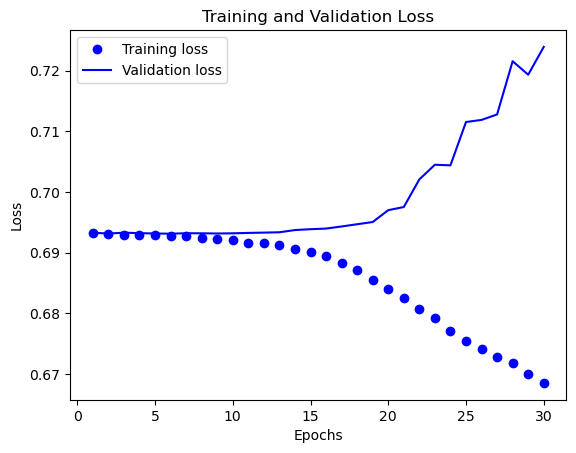

In [39]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
"""
Training and validation loss를 그려 보면, 몇 epoch까지의 트레이닝이 적절한지 
최적점을 추정해 볼 수 있습니다. validation loss의 그래프가 train loss와의
이격이 발생하게 되면 더 이상의 트레이닝은 무의미해지게 마련입니다.
"""

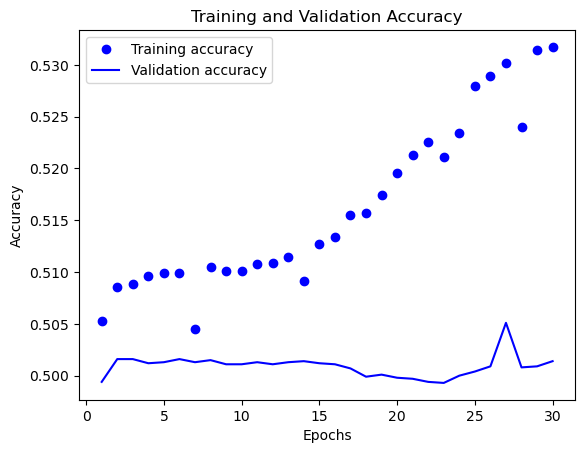

In [40]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
"""
마찬가지로 Training and validation accuracy를 그려 보아도 유사한 인사이트를 얻을 수 있습니다.

(3) Word2Vec의 적용
이전 스텝에서 라벨링 비용이 많이 드는 머신러닝 기반 감성분석의 비용을 절감하면서 
정확도를 크게 향상시킬 수 있는 자연어 처리 기법으로 단어의 특성을 저차원 벡터 값으로 
표현할 수 있는 워드 임베딩(word embedding) 기법이 있다는 언급을 한 바 있습니다.

우리는 이미 이전 스텝에서 워드 임베딩을 사용했습니다. 사용했던 model의 첫 번째 
레이어는 바로 Embedding 레이어였습니다. 이 레이어는 우리가 가진 사전의 단어 개수 
X 워드 벡터 사이즈만큼의 크기를 가진 학습 파라미터였습니다. 만약 우리의 감성 분류 
모델이 학습이 잘 되었다면, Embedding 레이어에 학습된 우리의 워드 벡터들도 의미 
공간상에 유의미한 형태로 학습되었을 것입니다. 한번 확인해 봅시다.

이번 스텝부터 워드 벡터 파일을 저장할 디렉터리를 먼저 생성합시다. 그리고 워드 
벡터를 다루는데 유용한 gensim 패키지를 설치합시다.
"""


In [41]:
# 이미, 오늘 첫 스텝에서 설치되었으니,
# 필요할 때만 Local terminal에서 아래 명령어를 입력해 주세요.
$ mkdir -p sentiment_classification/data
$ pip install gensim==4.3.2
$ pip install scipy==1.12.0 numpy==1.26.3

SyntaxError: invalid syntax (3976133325.py, line 3)

In [42]:
embedding_layer = model.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 16)


In [45]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.path.join(os.getenv('HOME') + '/word2vec.txt')

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

In [46]:
# gensim에서 제공하는 패키지를 이용해, 위에 남긴 임베딩 파라미터를 읽어서 word vector로 활용할 수 있습니다.
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

array([-0.39048597, -0.32171926, -0.49570125,  0.5987515 , -0.82346684,
       -0.50739485, -0.7251118 , -0.77163714, -0.14054525,  0.34299818,
       -1.1977164 , -0.38771814, -0.58220243, -1.4523695 , -1.3591638 ,
       -1.6058068 ], dtype=float32)

In [ ]:
"""
위와 같이 얻은 워드 벡터를 가지고 재미있는 실험을 해볼 수 있습니다. 
워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인하는 방법 중에, 
단어를 하나 주고 그와 가장 유사한 단어와 그 유사도를 확인하는 방법이 있습니다. 
gensim을 사용하면 아래와 같이 해볼 수 있습니다.
"""

In [47]:
word_vectors.similar_by_word("love")

[('remark', 0.8547155261039734),
 ('wins', 0.8032256364822388),
 ('native', 0.8018304705619812),
 ('underlying', 0.7979157567024231),
 ('victor', 0.7724127173423767),
 ('carpenter', 0.7408649325370789),
 ('producers', 0.7386540174484253),
 ('undeniably', 0.7164281010627747),
 ('natural', 0.7117794156074524),
 ('whacked', 0.7052521109580994)]

In [ ]:
"""
어떻습니까? love라는 단어와 유사한 다른 단어를 그리 잘 찾았다고 느껴지지는 않습니다.
감성 분류 태스크를 잠깐 학습한 것만으로 워드 벡터가 유의미하게 학습되기는 
어려운 것 같습니다. 우리가 다룬 정도의 훈련 데이터로는 워드 벡터를 정교하게 학습시키기
어렵습니다.

그래서 이번에는 구글에서 제공하는 Word2Vec이라는 사전학습된(Pretrained) 워드
임베딩 모델을 가져다 활용해 보겠습니다. Word2Vec은 무려 1억 개의 단어로 구성된 
Google News dataset을 바탕으로 학습되었습니다. 총 300만 개의 단어를 각각 300차원의
벡터로 표현한 것입니다. Word2Vec이 학습되는 원리에 대해서는 차후 깊이 있게 다루게 될 
것입니다. 하지만 그렇게 해서 학습된 Word2Vec이라는 것도 실은 방금 우리가 파일에 써본 
Embedding Layer와 원리는 동일합니다.

임베딩의 개념에 대해 아주 잘 정리된 책 한국어 임베딩의 서론에서 왜 사전학습된 임베딩을 
활용하는 것이 유리한지 설명해 주고 있습니다. 바로 전이학습 때문입니다. 관련 내용을
읽어본 후 질문에 답해 봅시다.

한국어 임베딩 서문
https://ratsgo.github.io/natural%20language%20processing/2019/09/12/embedding/

그러면 본격적으로 Google의 Word2Vec 모델을 가져와 적용해 봅시다.

이 링크를 클릭하면 무려 1.5GB 이상의 파일을 다운받게 됩니다. 다운받은 후에는 
다음과 같이 진행해 봅시다.
https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g

""""

In [58]:
mv ~/Downloads/GoogleNews-vectors-negative300.bin.gz ~/work/sentiment_classification

mv: cannot stat '/home/jovyan/Downloads/GoogleNews-vectors-negative300.bin.gz': No such file or directory


In [59]:
from gensim.models import KeyedVectors

word2vec_path = data_dir + 'GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [ ]:
"""
300dim의 벡터로 이루어진 300만 개의 단어입니다. 이 단어 사전을 메모리에 모두 로딩하면 
아주 높은 확률로 여러분의 실습환경에 메모리 에러가 날 것입니다. 
그래서 KeyedVectors.load_word2vec_format 메서드로 워드 벡터를 로딩할 때 가장 많이
사용되는 상위 100만 개만 limt으로 조건을 주어 로딩했습니다.

메모리가 충분하다면 limt=None으로 하시면 300만 개를 모두 로딩합니다.
"""

In [69]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [54]:
"""
어떻습니까? Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 
가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있습니다. 
이제 우리는 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여
다시 학습시켜 볼 것입니다.
"""

'\n어떻습니까? Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 \n가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있습니다. \n이제 우리는 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여\n다시 학습시켜 볼 것입니다.\n'

In [70]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentModel(nn.Module):
    def __init__(self, vocab_size, word_vector_dim, embedding_matrix, maxlen):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)    # 카피한 임베딩을 여기서 활용
        # self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight = nn.Parameter(
        embedding_matrix.detach().clone().float()
        )
        self.embedding.weight.requires_grad = True
        self.conv1 = nn.Conv1d(in_channels=word_vector_dim, out_channels=16, kernel_size=7)
        self.pool = nn.MaxPool1d(kernel_size=5)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=7)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.global_max_pool(x).squeeze(2)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수

embedding_matrix = torch.randn(vocab_size, word_vector_dim)

model = SentimentModel(vocab_size, word_vector_dim, embedding_matrix, maxlen)
print(model)

SentimentModel(
  (embedding): Embedding(10000, 300)
  (conv1): Conv1d(300, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)


In [75]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

# partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
# partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

# x_val_tensor = torch.tensor(x_val, dtype=torch.long)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float)
partial_x_train_tensor = partial_x_train.detach().clone().long()
partial_y_train_tensor = partial_y_train.detach().clone().float()

x_val_tensor = x_val.detach().clone().long()
y_val_tensor = y_val.detach().clone().float()

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

# 학습의 진행
epochs = 20    # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
# 테스트셋을 통한 모델 평가
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

In [ ]:
"""
어떻습니까? Word2Vec을 정상적으로 잘 활용하면 그렇지 않은 경우보다 
5% 이상의 성능 향상이 발생합니다. 적절한 모델 구성, 하이퍼파라미터를 고려하여 
감정 분석 모델의 성능을 최대한으로 끌어올려 봅시다.
"""